In [1]:
# install packages
!pip install librosa
!pip install pywt
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from pydub import AudioSegment
import pywt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
import itertools
import os
import pickle

In [3]:
def get_high_pass_filter(cutoff_freq, sr):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff_freq / nyquist
    return scipy.signal.butter(1, normal_cutoff, btype='high', analog=False)

def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

In [4]:
# target audio file
# file_path = '../audios/lab_audios/recording_20240927_134618.wav'
# y, sr = librosa.load(file_path)

# y = band_stop_filter(y, sr, highcut=900)

In [5]:
def produce_spectrogram(y, sr, cutoff_freq, method='stft', dur=20, vmin=0, vmax=0.5):
    y_filtered = y
    if dur != -1:
        y_filtered = y_filtered[:int(dur * sr)]
    if method == 'stft':
        D_filtered = librosa.stft(y_filtered)
        S_raw_filtered = np.abs(D_filtered)
        S_raw_filtered *= 10

#         print(f"Shape of D_filtered: {D_filtered.shape}")
#         print(f"Shape of S_raw_filtered: {S_raw_filtered.shape}")

        plt.figure(figsize=(12, 8))
        
        # Plot the spectrogram
        img = librosa.display.specshow(S_raw_filtered, sr=sr, x_axis='time', y_axis='log')

        plt.ylim(512, sr // 2)

        # Set the color limits for better visibility
        plt.clim(vmin=vmin, vmax=vmax)

        # Add color bar and customize the tick formatting to reflect amplitude values
        cbar = plt.colorbar(img, format='%+1.2f')  # Only one colorbar here

        # Add labels and title
        plt.title(f'Spectrogram (Frequency vs. Time) with High-Pass Filter at {cutoff_freq}Hz')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        
    if method == 'wavelet':
        scales = np.arange(1, 64)
        
        coef, freq = pywt.cwt(y_filtered, scales, 'cmor', sampling_period=1/sr)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(np.abs(coef), extent=[0, dur, scales[-1], scales[0]], cmap='viridis', aspect='auto',
                   vmax=np.abs(coef).max(), vmin=-np.abs(coef).max())
        plt.colorbar(label='Magnitude')
        plt.title('Wavelet Transform (CWT) of the Audio Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Scale')
        plt.yscale('log')
        plt.ylim(scales[-1], scales[0])
        plt.show()
        
        peak_frequencies = freq[np.argmax(np.abs(coef), axis=0)]
        times = np.linspace(0, dur, len(peak_frequencies))

        plt.figure(figsize=(12, 8))
        plt.plot(times, peak_frequencies, label='Peak Frequency')
        plt.ylim(512, 10000)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'Peak Frequency Over Time for First {dur} Seconds')
        plt.legend()
        plt.show()

In [6]:
def filter_response_plots(y, sr, freq):
    b, a = get_high_pass_filter(freq, sr_ft)
    w, h = scipy.signal.freqz(b, a)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(0.5 * sr * w / np.pi, np.abs(h), 'b')
    plt.title('High-Pass Filter Frequency Response - Gain')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(0.5 * sr * w / np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    magnitude_dB = 20 * np.log10(np.abs(h))  # Convert magnitude to dB
    plt.plot(0.5 * sr * w / np.pi, magnitude_dB, 'b')
    plt.title('High-Pass Filter Frequency Response - dB')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain [dB]')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(0.5 * sr * w / np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid()

    plt.tight_layout()
    plt.show()

In [7]:
# produce_spectrogram(y, sr, 900, method='stft', dur=-1)

In [8]:
# produce_spectrogram(y_ft, sr_ft, 900, method='wavelet', dur=-1)

In [9]:
def detect_energy_peaks(S_filtered, sr, height, distance, amp_min=80, amp_max=320):
    energy_over_time = np.sum(S_filtered, axis=0)
    
    peaks, _ = scipy.signal.find_peaks(energy_over_time, height=height, distance=distance)
    
    peaks = [p for p in peaks if amp_min <= energy_over_time[p] <= amp_max]
    
    baseline_energy = []
    for i in range(len(peaks) - 1):
        start_idx = peaks[i]
        end_idx = peaks[i + 1]
        baseline_seg = energy_over_time[start_idx: end_idx]
        
        baseline_val = baseline_seg[baseline_seg < np.median(baseline_seg)]
        baseline_energy.extend(baseline_val)
        
    amp_threshold = np.mean(baseline_energy) + 3 * np.std(baseline_energy)
    
    print(f'mean: {np.mean(baseline_energy)}')
    print(f'amp threshold: {amp_threshold}')
    
    times = librosa.frames_to_time(peaks, sr=sr)
    full_times = librosa.frames_to_time(np.arange(S_filtered.shape[1]), sr=sr, hop_length=512)
    
    plt.figure(figsize=(10, 6))
    plt.plot(full_times, energy_over_time, label='Energy Over Time (Raw Amplitude)')
    plt.scatter(times, energy_over_time[peaks], color='red', label='Detected Peaks')

    time_segments = []
    start_end_times = []

    for peak_idx in peaks:
        start_idx = peak_idx
        while start_idx > 0 and energy_over_time[start_idx] > amp_threshold:
            start_idx -= 1
        
        end_idx = peak_idx
        while end_idx < len(energy_over_time) - 1 and energy_over_time[end_idx] > amp_threshold:
            end_idx += 1

        start_time = librosa.frames_to_time(start_idx, sr=sr, hop_length=512)
        end_time = librosa.frames_to_time(end_idx, sr=sr, hop_length=512)
        
        if start_time < end_time:
            time_segments.append((start_time, end_time))
            start_end_times.append((start_time, end_time))

    for (start_time, end_time) in start_end_times:
        plt.fill_between(full_times, energy_over_time, where=((full_times >= start_time) & (full_times <= end_time)),
                         color='yellow', alpha=0.3, label='Detected Interval' if start_time == start_end_times[0][0] else "")

    plt.xlabel('Time (s)')
    plt.ylabel('Energy (Sum of Raw Amplitudes)')
    plt.title('Energy Over Time with Detected Peaks and Trimmed Intervals')
    plt.legend()
    plt.show()

    print(f'# of snippets: {len(time_segments)}')
    
    return time_segments, energy_over_time

def decompose_freq(file_path, y, sr, height, distance, time_seg_dur=0.2, dur=20, amp_min=80, amp_max=320):
    if dur != -1:
        y = y[:int(dur * sr)]
        
    D_filtered = librosa.stft(y)
    S_filtered = np.abs(D_filtered)
        
    time_segments, energy_over_time = detect_energy_peaks(S_filtered, sr, height=height, distance=distance, amp_min=amp_min, amp_max=amp_max)
    
    plt.figure(figsize=(10, 6))
    segments_data = []

    for start_time, end_time in time_segments:
        start_idx = librosa.time_to_frames(start_time, sr=sr)
        end_idx = librosa.time_to_frames(end_time, sr=sr)

        segment_slice = S_filtered[:, start_idx:end_idx]
        avg_spectrum = np.mean(segment_slice, axis=1)
        frequencies = librosa.fft_frequencies(sr=sr, n_fft=D_filtered.shape[0] * 2 - 1)

        plt.plot(frequencies, avg_spectrum, label=f"Time {start_time:.2f}-{end_time:.2f}s")
        segments_data.append({
            'spectrum': avg_spectrum,
            'start_time': start_time,
            'end_time': end_time,
            'file_name': file_path
        })
        
    plt.ylim(0, None)
    plt.xlim(512, sr // 2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (Raw)')
    plt.title('Frequency Decomposition for All Time Intervals')

    plt.legend()
    plt.show()
    
    return segments_data


In [10]:
# time_segments = decompose_freq(y, sr, dur=-1, height=50, distance=25)

In [11]:
def generate_pairs(n):
    pairs = list(itertools.combinations(range(n), 2))
    return pairs

def perform_pca_on_segments(y, sr, time_segments, n_comp=4):               
    data_matrix = np.array(data_matrix)
    
    scaler = StandardScaler()
    data_matrix_std = scaler.fit_transform(data_matrix)
    
    pca = PCA(n_components=n_comp)
    pca_result = pca.fit_transform(data_matrix_std)
    
    explained_variance = pca.explained_variance_ratio_
    print(f'Explained variance by the components: {explained_variance}')

    component_pairs = generate_pairs(n_comp)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for ax, (i, j) in zip(axes.flat, component_pairs):
        ax.scatter(pca_result[:, i], pca_result[:, j], c='blue', marker='o')
        ax.set_title(f'PCA Components {i+1}-{j+1}')
        ax.set_xlabel(f'PC {i+1} ({explained_variance[i]*100:.2f}% variance)')
        ax.set_ylabel(f'PC {j+1} ({explained_variance[j]*100:.2f}% variance)')

    plt.tight_layout()
    plt.show()

In [12]:
# perform_pca_on_segments(y, sr, time_segments)

In [13]:
def process_audio_and_extract_segments(file_path, dur=-1, height=50, distance=25, amp_min=80, amp_max=320):
    y, sr = librosa.load(file_path)
    
    y_filtered = band_stop_filter(y, sr, highcut=900)  # Assuming this function is already available
    
    return decompose_freq(file_path, y_filtered, sr, dur=dur, height=height, distance=distance, amp_min=amp_min, amp_max=amp_max)

def perform_pca_on_segments(all_segments, n_components=4):
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(all_segments)
    
    print(f"Explained variance by the components: {pca.explained_variance_ratio_}")
    
    return pca_transformed, pca

def plot_pca_results(pca_transformed, n_components):
    pairs = [(0, 1), (1, 2), (2, 3), (0, 2), (0, 3), (1, 3)]
    
    plt.figure(figsize=(12, 8))
    
    for (i, (comp1, comp2)) in enumerate(pairs):
        plt.subplot(2, 3, i+1)
        plt.scatter(pca_transformed[:, comp1], pca_transformed[:, comp2], alpha=0.6, edgecolors='w', s=50)
        plt.title(f'PCA Components {comp1+1} vs {comp2+1}')
        plt.xlabel(f'Component {comp1+1}')
        plt.ylabel(f'Component {comp2+1}')
    
    plt.tight_layout()
    plt.show()

All segments have been loaded from all_segments.pkl
Explained variance by the components: [0.36140734 0.09899641 0.08232874 0.06250473]


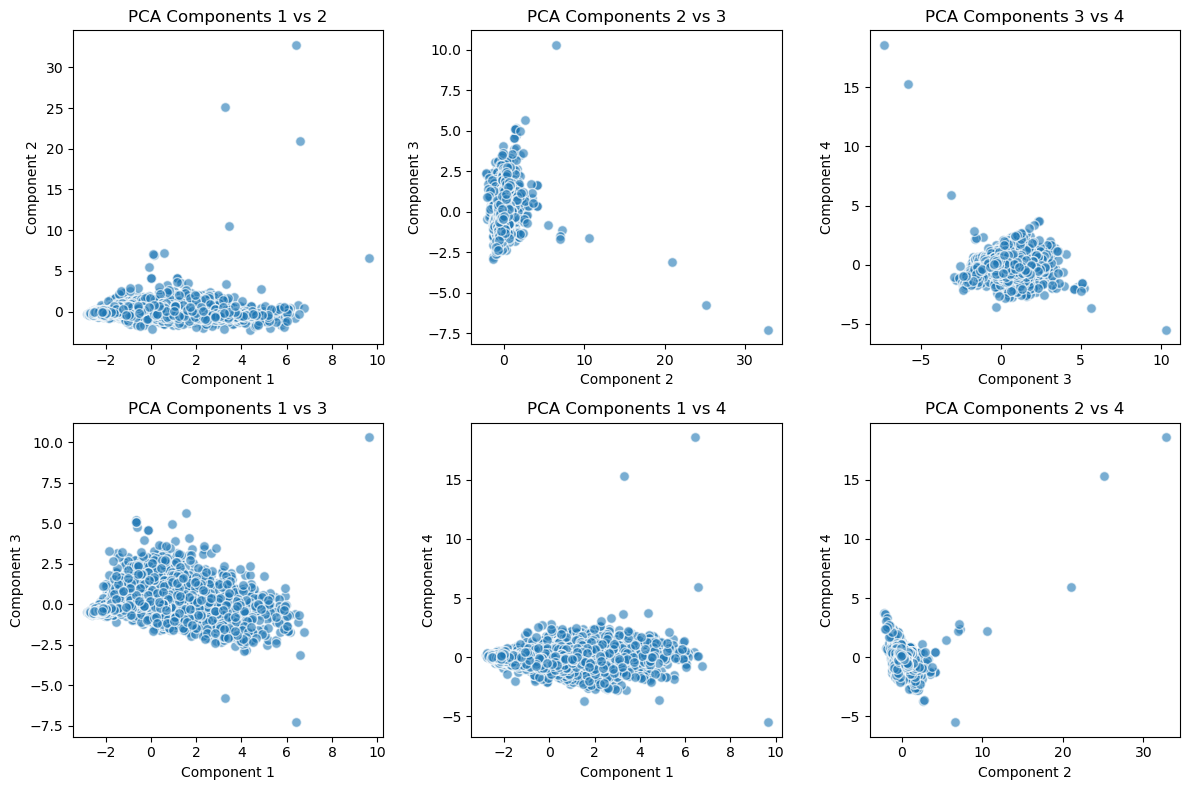

In [14]:
folder_path = '../audios/lab_audios/first_batch/'
# file_names = [f'recording_20240927_204919-{i:02d}.wav' for i in range(1, 17)]
# all_segments = []
# for f in file_names:
#     file_path = os.path.join(folder_path, f)
#     print(f'Processing file: {file_path}')
#     segments = process_audio_and_extract_segments(file_path)
#     all_segments.extend(segments)
    
# with open(f'{folder_path}all_segments.pkl', 'wb') as file:
#     pickle.dump(all_segments, file)

# print(f'All segments have been saved to all_segments.pkl')

with open(f'{folder_path}all_segments.pkl', 'rb') as file:
    all_segments = pickle.load(file)

print(f'All segments have been loaded from all_segments.pkl')

spectrums = np.array([s['spectrum'] for s in all_segments])
pca_transformed, pca = perform_pca_on_segments(spectrums)
plot_pca_results(pca_transformed, n_components=4)

In [15]:
def run_kmeans_full(data, n_clusters=4):
    spectrums = np.array([s['spectrum'] for s in all_segments])
    kmeans_full = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_full = kmeans_full.fit_predict(spectrums)
    
    for i, label in enumerate(labels_full):
        file_name = data[i]['file_name'][-6:-4]
        start_t = data[i]['start_time']
        end_t = data[i]['end_time']
        data[i]['cluster'] = label
        print(f'File: {file_name}, {start_t} : {end_t}: Cluster {label}')
    return labels_full

In [16]:
n_clusters = 5
labels_full = run_kmeans_full(all_segments, n_clusters)

File: 01, 15.185850340136055 : 15.74312925170068: Cluster 0
File: 01, 16.671927437641724 : 17.22920634920635: Cluster 1
File: 01, 22.430476190476192 : 23.173514739229024: Cluster 1
File: 01, 42.05133786848072 : 42.6550566893424: Cluster 1
File: 01, 43.1891156462585 : 43.723174603174606: Cluster 1
File: 01, 45.2324716553288 : 45.7665306122449: Cluster 1
File: 01, 523.1920181405895 : 523.5403174603175: Cluster 0
File: 01, 524.4226757369614 : 525.5372335600907: Cluster 0
File: 01, 525.5372335600907 : 526.4892517006803: Cluster 0
File: 01, 527.8360090702948 : 528.6254875283447: Cluster 0
File: 01, 528.8344671201814 : 528.9970068027211: Cluster 0
File: 01, 529.786485260771 : 530.2508843537415: Cluster 0
File: 01, 530.2508843537415 : 532.1317006802722: Cluster 0
File: 01, 572.952380952381 : 573.2542403628117: Cluster 0
File: 01, 575.4369160997733 : 575.6923356009071: Cluster 0
File: 01, 585.5608163265306 : 585.8162358276644: Cluster 0
File: 01, 595.6150566893424 : 596.0562358276644: Cluster 

In [17]:
def group_segments_by_cluster(all_segments, n_clusters):
    clusters = [[] for _ in range(n_clusters)]
    for segment in all_segments:
        cluster_label = segment['cluster']
        clusters[cluster_label].append(segment)
    return clusters

def concatenate_audio_snippets(cluster_segments, silence_duration=500):
    combined_audio = AudioSegment.silent(duration=0)
    silence = AudioSegment.silent(duration=silence_duration)
    cnt = 0
    for segment in cluster_segments:
        cnt += 1
        print(f'constantly processing segments{cnt}')
        audio_snippet = AudioSegment.from_wav(segment['file_name'])
        start_time = segment['start_time'] * 1000
        end_time = segment['end_time'] * 1000
        
        snippet = audio_snippet[start_time:end_time]
        
        combined_audio += snippet + silence
    
    return combined_audio

def save_combined_audio(combined_audio, output_path):
    combined_audio.export(output_path, format="wav")
    print(f"Combined audio saved to {output_path}")

In [37]:
def combine_audio(all_segments, n_clusters, suffix):
    clustered_segments = group_segments_by_cluster(all_segments, n_clusters)

    for cluster_index, cluster_segments in enumerate(clustered_segments):
        if cluster_segments:
            print(len(cluster_segments))
#             combined_audio = concatenate_audio_snippets(cluster_segments)
#             output_path = f'../audios/lab_audios/first_batch/combined_audio_cluster_{cluster_index}{suffix}.wav'
#             save_combined_audio(combined_audio, output_path)

In [19]:
combine_audio(all_segments, n_clusters, suffix='')

1650
902
447
3
582


In [20]:
def plot_pca_clusters(pca_transformed, labels, n_components=4):
    """Plot PCA-transformed data with color-coding based on cluster labels."""
    plt.figure(figsize=(12, 8))
    
    # Define a color map to distinguish clusters
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # 'tab10' colormap for 10 distinct colors
    
    # Create pairwise PCA component plots (e.g., 1 vs 2, 2 vs 3, etc.)
    component_pairs = [(0, 1), (1, 2), (2, 3), (0, 2), (0, 3), (1, 3)]
    
    for idx, (i, j) in enumerate(component_pairs):
        plt.subplot(2, 3, idx + 1)
        for label in unique_labels:
            cluster_data = pca_transformed[labels == label]  # Data points in this cluster
            plt.scatter(cluster_data[:, i], cluster_data[:, j], label=f"Cluster {label}", alpha=0.6, cmap='tab10')
        plt.xlabel(f'Component {i+1}')
        plt.ylabel(f'Component {j+1}')
        plt.title(f'PCA Components {i+1} vs {j+1}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

/var/folders/rh/ls0tg20j3l1gps3pmz8g3bkm0000gn/T/ipykernel_36482/1135326821.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # 'tab10' colormap for 10 distinct colors
/var/folders/rh/ls0tg20j3l1gps3pmz8g3bkm0000gn/T/ipykernel_36482/1135326821.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster_data[:, i], cluster_data[:, j], label=f"Cluster {label}", alpha=0.6, cmap='tab10')


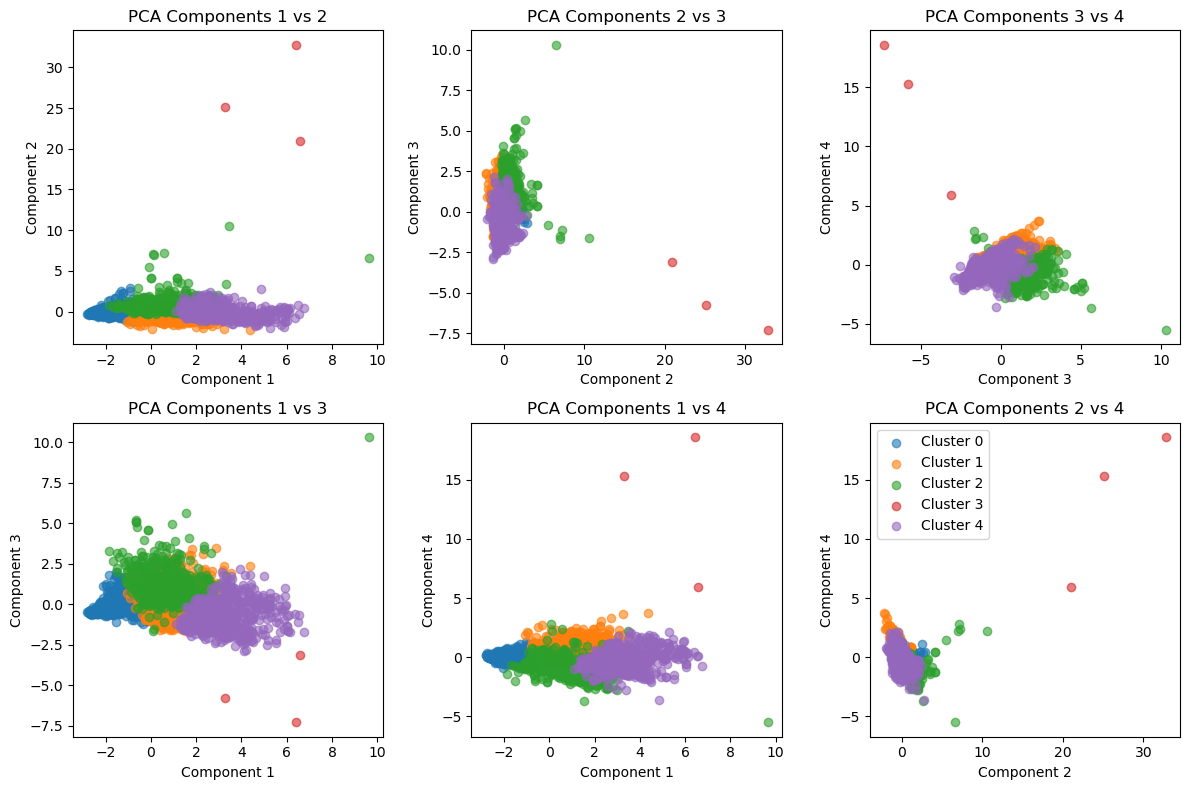

In [21]:
plot_pca_clusters(pca_transformed, labels_full)

In [22]:
def plot_explained_variance(spectrums, n_components=100):
    pca = PCA(n_components=n_components)
    pca.fit(spectrums)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.6, align='center',
            label='Individual Explained Variance')
    plt.step(range(1, n_components + 1), np.cumsum(explained_variance_ratio), where='mid',
             label='Cumulative Explained Variance', color='red')
    
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'Explained Variance by Principal Components (up to {n_components} PCs)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return np.cumsum(explained_variance_ratio)

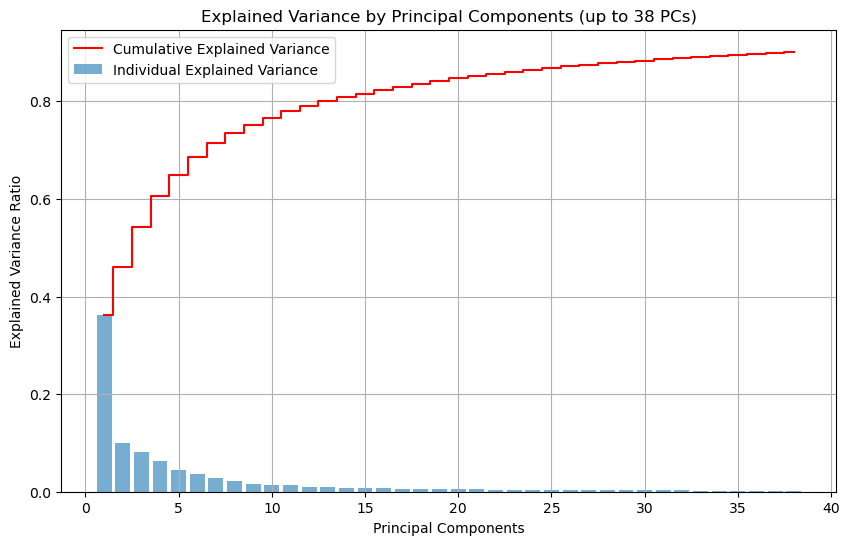

array([0.36140734, 0.46040375, 0.54273249, 0.60523722, 0.64950582,
       0.68659889, 0.71462546, 0.7356039 , 0.75172968, 0.76631412,
       0.78010273, 0.79066397, 0.80035703, 0.80822416, 0.81562029,
       0.82294124, 0.82940236, 0.83563623, 0.84142926, 0.84680654,
       0.85180683, 0.85630522, 0.86061923, 0.86448448, 0.86810026,
       0.87137618, 0.87450478, 0.87754548, 0.88046424, 0.88323047,
       0.88592519, 0.8885893 , 0.89096527, 0.89328826, 0.89554866,
       0.89766163, 0.89969139, 0.90161253])

In [23]:
plot_explained_variance(spectrums, n_components=38)

In [24]:
def perform_pca_and_kmeans(data, n_components, n_clusters=4, pca=True):
    spectrums = np.array([s['spectrum'] for s in all_segments])
    if pca:
        pca = PCA(n_components=n_components)
        pca_transformed = pca.fit_transform(spectrums)
    else:
        pca = None
        pca_transformed = spectrums
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_transformed)
    
    cluster_sizes = np.bincount(labels)
    
    sorted_cluster_indices = np.argsort(-cluster_sizes)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_cluster_indices)}
    
    reordered_labels = np.array([label_mapping[label] for label in labels])
    
    for i, label in enumerate(reordered_labels):
        file_name = data[i]['file_name'][-6:-4]
        start_t = data[i]['start_time']
        end_t = data[i]['end_time']
        data[i]['cluster'] = label
        # print(f'File: {file_name}, {start_t} : {end_t}: Cluster {label}')
    
    return pca_transformed, reordered_labels, pca

In [25]:
n_clusters = 5
pca_transformed_90, labels_90, pca_90 = perform_pca_and_kmeans(all_segments, n_components=38, n_clusters=n_clusters)

combine_audio(all_segments, n_clusters, '-90pcaEd')

1649
909
580
443
3


In [26]:
pca_transformed_80, labels_80, pca_80 = perform_pca_and_kmeans(all_segments, n_components=13, n_clusters=n_clusters)

combine_audio(all_segments, n_clusters, '-80pcaEd')

1646
894
589
452
3


In [27]:
_, labels_full, _ = perform_pca_and_kmeans(all_segments, n_components=38, n_clusters=n_clusters, pca=False)

combine_audio(all_segments, n_clusters, 'full')

1650
902
582
447
3


In [28]:
def compare_clusters(labels1, labels2, data, name1="90%", name2="full"):
    n_clusters = max(np.max(labels1), np.max(labels2)) + 1
    comparisons = {}

    for cluster in range(n_clusters):
        indices_1 = set(np.where(labels1 == cluster)[0])
        indices_2 = set(np.where(labels2 == cluster)[0])

        common_points = indices_1.intersection(indices_2)
        unique_to_1 = indices_1 - indices_2
        unique_to_2 = indices_2 - indices_1

        comparisons[cluster] = {
            "common": common_points,
            "unique_to_1": unique_to_1,
            "unique_to_2": unique_to_2,
        }

        print(f"\nComparison for Cluster {cluster} ({name1} vs {name2}):")
        # print(f"Common data points ({len(common_points)}): {sorted(common_points)}")
        print(f"Unique to {name1} ({len(unique_to_1)}): {sorted(unique_to_1)}")
        print(f"Unique to {name2} ({len(unique_to_2)}): {sorted(unique_to_2)}")

    return comparisons


comp_90_full = compare_clusters(labels_90, labels_full, all_segments, name1="90%", name2="full")

comp_80_full = compare_clusters(labels_80, labels_full, all_segments, name1="80%", name2="full")



Comparison for Cluster 0 (90% vs full):
Unique to 90% (0): []
Unique to full (1): [1711]

Comparison for Cluster 1 (90% vs full):
Unique to 90% (11): [458, 556, 708, 773, 1036, 1187, 1711, 1943, 2219, 3049, 3386]
Unique to full (4): [2997, 3355, 3356, 3357]

Comparison for Cluster 2 (90% vs full):
Unique to 90% (1): [2997]
Unique to full (3): [1378, 1383, 2219]

Comparison for Cluster 3 (90% vs full):
Unique to 90% (5): [1378, 1383, 3355, 3356, 3357]
Unique to full (9): [458, 556, 708, 773, 1036, 1187, 1943, 3049, 3386]

Comparison for Cluster 4 (90% vs full):
Unique to 90% (0): []
Unique to full (0): []

Comparison for Cluster 0 (80% vs full):
Unique to 80% (0): []
Unique to full (4): [1220, 1707, 1945, 2661]

Comparison for Cluster 1 (80% vs full):
Unique to 80% (9): [458, 1036, 1220, 1707, 1943, 1945, 2219, 2661, 3386]
Unique to full (17): [322, 323, 409, 693, 730, 747, 809, 891, 1120, 1978, 2004, 2997, 3175, 3355, 3356, 3357, 3469]

Comparison for Cluster 2 (80% vs full):
Unique t

In [29]:
def perform_pca_and_dbscan(data, n_components=38, eps=0.5, min_samples=5, pca=False):
    spectrums = np.array([s['spectrum'] for s in data])
    if pca:
        pca = PCA(n_components=n_components)
        pca_transformed = pca.fit_transform(spectrums)
    else:
        pca = None
        pca_transformed = spectrums
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(pca_transformed)
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels[sorted_indices])}
    
    reordered_labels = np.array([label_mapping[label] if label != -1 else -1 for label in labels])
    
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1])
    
    for i, label in enumerate(reordered_labels):
        file_name = data[i]['file_name'][-6:-4]
        start_t = data[i]['start_time']
        end_t = data[i]['end_time']
        data[i]['cluster'] = label
        # print(f'File: {file_name}, {start_t} : {end_t}: Cluster {label}')
        
    return pca_transformed, reordered_labels, pca, n_clusters

In [30]:
pca_transformed, labels_dbscan, pca_model, n_clusters = perform_pca_and_dbscan(all_segments, eps=1, min_samples=5)
print(n_clusters)
combine_audio(all_segments, n_clusters+1, '-DBSCAN')

6
965
6
5
5
5
2598


In [35]:
def perform_hierarchical_clustering(data, method='ward', distance_threshold=None, plot_dendrogram=True):
    spectrums = np.array([s['spectrum'] for s in data])
    scaler = StandardScaler()
    spectrums = scaler.fit_transform(spectrums)
    
    Z = linkage(spectrums, method=method)
    
    if plot_dendrogram:
        plt.figure(figsize=(10, 7))
        dendrogram(Z)
        plt.title("Dendrogram for Hierarchical Clustering")
        plt.xlabel("Data Points")
        plt.ylabel("Distance")
        plt.show()
    
    if distance_threshold is not None:
        labels = fcluster(Z, t=distance_threshold, criterion='distance')
        num_clusters = len(np.unique(labels))
        print(f'Num clusters: {num_clusters}')
    else:
        raise ValueError("Please specify a distance_threshold to form clusters.")
        
    for i, label in enumerate(labels):
        file_name = data[i]['file_name'][-6:-4]
        start_t = data[i]['start_time']
        end_t = data[i]['end_time']
        data[i]['cluster'] = label
        # print(f'File: {file_name}, {start_t} : {end_t}: Cluster {label}')
        
    return labels, num_clusters

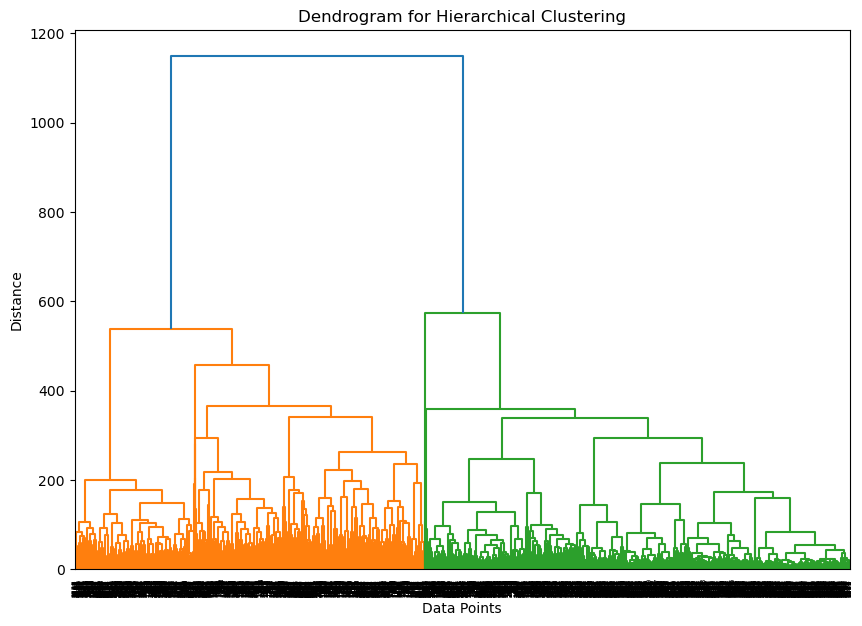

Num clusters: 13
553
constantly processing segments1
constantly processing segments2
constantly processing segments3
constantly processing segments4
constantly processing segments5
constantly processing segments6
constantly processing segments7
constantly processing segments8
constantly processing segments9
constantly processing segments10
constantly processing segments11
constantly processing segments12
constantly processing segments13
constantly processing segments14
constantly processing segments15
constantly processing segments16
constantly processing segments17
constantly processing segments18
constantly processing segments19
constantly processing segments20
constantly processing segments21
constantly processing segments22
constantly processing segments23
constantly processing segments24
constantly processing segments25
constantly processing segments26
constantly processing segments27
constantly processing segments28
constantly processing segments29
constantly processing segments3

constantly processing segments245
constantly processing segments246
constantly processing segments247
constantly processing segments248
constantly processing segments249
constantly processing segments250
constantly processing segments251
constantly processing segments252
constantly processing segments253
constantly processing segments254
constantly processing segments255
constantly processing segments256
constantly processing segments257
constantly processing segments258
constantly processing segments259
constantly processing segments260
constantly processing segments261
constantly processing segments262
constantly processing segments263
constantly processing segments264
constantly processing segments265
constantly processing segments266
constantly processing segments267
constantly processing segments268
constantly processing segments269
constantly processing segments270
constantly processing segments271
constantly processing segments272
constantly processing segments273
constantly pro

constantly processing segments486
constantly processing segments487
constantly processing segments488
constantly processing segments489
constantly processing segments490
constantly processing segments491
constantly processing segments492
constantly processing segments493
constantly processing segments494
constantly processing segments495
constantly processing segments496
constantly processing segments497
constantly processing segments498
constantly processing segments499
constantly processing segments500
constantly processing segments501
constantly processing segments502
constantly processing segments503
constantly processing segments504
constantly processing segments505
constantly processing segments506
constantly processing segments507
constantly processing segments508
constantly processing segments509
constantly processing segments510
constantly processing segments511
constantly processing segments512
constantly processing segments513
constantly processing segments514
constantly pro

constantly processing segments160
constantly processing segments161
constantly processing segments162
constantly processing segments163
constantly processing segments164
constantly processing segments165
constantly processing segments166
constantly processing segments167
constantly processing segments168
constantly processing segments169
constantly processing segments170
constantly processing segments171
constantly processing segments172
constantly processing segments173
constantly processing segments174
constantly processing segments175
constantly processing segments176
constantly processing segments177
constantly processing segments178
constantly processing segments179
constantly processing segments180
constantly processing segments181
constantly processing segments182
constantly processing segments183
constantly processing segments184
constantly processing segments185
constantly processing segments186
constantly processing segments187
constantly processing segments188
constantly pro

constantly processing segments401
constantly processing segments402
Combined audio saved to ../audios/lab_audios/first_batch/combined_audio_cluster_5-hierarical.wav
137
constantly processing segments1
constantly processing segments2
constantly processing segments3
constantly processing segments4
constantly processing segments5
constantly processing segments6
constantly processing segments7
constantly processing segments8
constantly processing segments9
constantly processing segments10
constantly processing segments11
constantly processing segments12
constantly processing segments13
constantly processing segments14
constantly processing segments15
constantly processing segments16
constantly processing segments17
constantly processing segments18
constantly processing segments19
constantly processing segments20
constantly processing segments21
constantly processing segments22
constantly processing segments23
constantly processing segments24
constantly processing segments25
constantly proc

constantly processing segments104
constantly processing segments105
constantly processing segments106
constantly processing segments107
constantly processing segments108
constantly processing segments109
constantly processing segments110
constantly processing segments111
constantly processing segments112
constantly processing segments113
constantly processing segments114
constantly processing segments115
constantly processing segments116
constantly processing segments117
constantly processing segments118
constantly processing segments119
constantly processing segments120
constantly processing segments121
constantly processing segments122
constantly processing segments123
constantly processing segments124
constantly processing segments125
constantly processing segments126
constantly processing segments127
constantly processing segments128
constantly processing segments129
constantly processing segments130
constantly processing segments131
constantly processing segments132
constantly pro

constantly processing segments31
constantly processing segments32
constantly processing segments33
constantly processing segments34
constantly processing segments35
constantly processing segments36
constantly processing segments37
constantly processing segments38
constantly processing segments39
constantly processing segments40
constantly processing segments41
constantly processing segments42
constantly processing segments43
constantly processing segments44
constantly processing segments45
constantly processing segments46
constantly processing segments47
constantly processing segments48
constantly processing segments49
constantly processing segments50
constantly processing segments51
constantly processing segments52
constantly processing segments53
constantly processing segments54
constantly processing segments55
constantly processing segments56
constantly processing segments57
constantly processing segments58
constantly processing segments59
constantly processing segments60
constantly

constantly processing segments45
constantly processing segments46
constantly processing segments47
constantly processing segments48
constantly processing segments49
constantly processing segments50
constantly processing segments51
constantly processing segments52
constantly processing segments53
constantly processing segments54
constantly processing segments55
constantly processing segments56
constantly processing segments57
constantly processing segments58
constantly processing segments59
constantly processing segments60
constantly processing segments61
constantly processing segments62
constantly processing segments63
constantly processing segments64
constantly processing segments65
constantly processing segments66
constantly processing segments67
constantly processing segments68
constantly processing segments69
constantly processing segments70
constantly processing segments71
constantly processing segments72
constantly processing segments73
constantly processing segments74
constantly

constantly processing segments288
constantly processing segments289
constantly processing segments290
constantly processing segments291
constantly processing segments292
constantly processing segments293
constantly processing segments294
constantly processing segments295
constantly processing segments296
constantly processing segments297
constantly processing segments298
constantly processing segments299
constantly processing segments300
constantly processing segments301
constantly processing segments302
constantly processing segments303
constantly processing segments304
constantly processing segments305
constantly processing segments306
constantly processing segments307
constantly processing segments308
constantly processing segments309
constantly processing segments310
constantly processing segments311
constantly processing segments312
constantly processing segments313
constantly processing segments314
constantly processing segments315
constantly processing segments316
constantly pro

constantly processing segments529
constantly processing segments530
constantly processing segments531
constantly processing segments532
constantly processing segments533
constantly processing segments534
constantly processing segments535
constantly processing segments536
constantly processing segments537
constantly processing segments538
constantly processing segments539
constantly processing segments540
constantly processing segments541
constantly processing segments542
constantly processing segments543
constantly processing segments544
constantly processing segments545
constantly processing segments546
constantly processing segments547
constantly processing segments548
constantly processing segments549
constantly processing segments550
constantly processing segments551
constantly processing segments552
constantly processing segments553
constantly processing segments554
constantly processing segments555
constantly processing segments556
constantly processing segments557
constantly pro

constantly processing segments86
constantly processing segments87
constantly processing segments88
constantly processing segments89
constantly processing segments90
constantly processing segments91
constantly processing segments92
constantly processing segments93
constantly processing segments94
constantly processing segments95
constantly processing segments96
constantly processing segments97
constantly processing segments98
constantly processing segments99
constantly processing segments100
constantly processing segments101
constantly processing segments102
constantly processing segments103
constantly processing segments104
constantly processing segments105
constantly processing segments106
constantly processing segments107
constantly processing segments108
constantly processing segments109
constantly processing segments110
constantly processing segments111
constantly processing segments112
constantly processing segments113
constantly processing segments114
constantly processing segmen

constantly processing segments115
constantly processing segments116
constantly processing segments117
constantly processing segments118
constantly processing segments119
constantly processing segments120
constantly processing segments121
constantly processing segments122
constantly processing segments123
constantly processing segments124
constantly processing segments125
constantly processing segments126
constantly processing segments127
constantly processing segments128
constantly processing segments129
constantly processing segments130
constantly processing segments131
constantly processing segments132
constantly processing segments133
constantly processing segments134
constantly processing segments135
constantly processing segments136
constantly processing segments137
constantly processing segments138
constantly processing segments139
constantly processing segments140
constantly processing segments141
constantly processing segments142
constantly processing segments143
constantly pro

constantly processing segments356
constantly processing segments357
constantly processing segments358
constantly processing segments359
constantly processing segments360
constantly processing segments361
constantly processing segments362
constantly processing segments363
constantly processing segments364
constantly processing segments365
constantly processing segments366
constantly processing segments367
constantly processing segments368
constantly processing segments369
constantly processing segments370
constantly processing segments371
constantly processing segments372
constantly processing segments373
constantly processing segments374
constantly processing segments375
constantly processing segments376
constantly processing segments377
constantly processing segments378
constantly processing segments379
constantly processing segments380
constantly processing segments381
constantly processing segments382
constantly processing segments383
constantly processing segments384
constantly pro

constantly processing segments597
constantly processing segments598
constantly processing segments599
constantly processing segments600
constantly processing segments601
constantly processing segments602
constantly processing segments603
constantly processing segments604
constantly processing segments605
constantly processing segments606
constantly processing segments607
constantly processing segments608
constantly processing segments609
constantly processing segments610
constantly processing segments611
constantly processing segments612
constantly processing segments613
constantly processing segments614
constantly processing segments615
constantly processing segments616
constantly processing segments617
constantly processing segments618
constantly processing segments619
constantly processing segments620
constantly processing segments621
constantly processing segments622
constantly processing segments623
constantly processing segments624
constantly processing segments625
constantly pro

constantly processing segments838
constantly processing segments839
constantly processing segments840
constantly processing segments841
constantly processing segments842
constantly processing segments843
constantly processing segments844
constantly processing segments845
constantly processing segments846
constantly processing segments847
constantly processing segments848
constantly processing segments849
constantly processing segments850
constantly processing segments851
constantly processing segments852
constantly processing segments853
constantly processing segments854
constantly processing segments855
constantly processing segments856
constantly processing segments857
constantly processing segments858
constantly processing segments859
constantly processing segments860
constantly processing segments861
constantly processing segments862
constantly processing segments863
constantly processing segments864
constantly processing segments865
constantly processing segments866
constantly pro

In [38]:
distance_threshold = 250
labels_hierarchical, n_clusters = perform_hierarchical_clustering(all_segments, method='ward', distance_threshold=distance_threshold)
combine_audio(all_segments, n_clusters + 1, '-hierarical')

In [ ]:
def perform_spectral_clustering(data, n_clusters, affinity='nearest_neighbors', plot_clusters=True):
    spectrums = np.array([s['spectrum'] for s in data])
    scaler = StandardScaler()
    spectrums = scaler.fit_transform(spectrums)
    
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity, random_state=42)
    labels = spectral.fit_predict(spectrums)
    
    num_clusters = len(np.unique(labels))
    print(f'Number of clusters: {num_clusters}')
    
    for i, label in enumerate(labels):
        file_name = data[i]['file_name'][-6:-4]
        start_t = data[i]['start_time']
        end_t = data[i]['end_time']
        data[i]['cluster'] = label
        # print(f'File: {file_name}, {start_t} : {end_t}: Cluster {label}')
    
    if plot_clusters and spectrums.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(spectrums[:, 0], spectrums[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        plt.title("Spectral Clustering")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.colorbar(label="Cluster Label")
        plt.show()
    
    return labels

In [ ]:
labels_sc = perform_spectral_clustering(all_segments, n_clusters)
combine_audio(all_segments, n_clusters, '-sc')